In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from lib.data_loader import IITG_DataLoader
from lib.functions import Functions
from lib.imputer import DataImputer
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
functions = Functions()
imputer = DataImputer()

In [3]:
# Load power import data
folder_path = 'power_import_data/'
apdcl_import = IITG_DataLoader()
raw_import_data = apdcl_import.load_all(folder_path, interpolate=False, power_header='MW', \
                                        start_time='2022-02-02', end_time='2022-12-31')
raw_import_data.loc[raw_import_data['Power'] > 10, 'Power'] = None

In [4]:
# Load pv generation (phase 2) data
folder_path = 'pv_gen_data/'
pv_gen = IITG_DataLoader()
solar_data = pv_gen.load_all(folder_path, interpolate=False, time_header='x1', power_header='ActivePower',\
                 start_time='2022-02-02', end_time='2022-12-31')
# Divide solar power values by 1000 to convert it from kWh to MWh
solar_data = solar_data[solar_data['Power'] > 0]
solar_data.loc[:,'Power'] = solar_data['Power']/1000

In [5]:
# Compute total demand data
# Total Demand = Power Import + 1.9 * PV Generation (Phase 2)
demand_data = pd.merge(raw_import_data, solar_data, suffixes=('_import', '_solar'), \
                     left_index=True, right_index=True, how='left')
demand_data['Power_solar'].fillna(0, inplace=True)
demand_data['Power'] = demand_data['Power_import'] + 1.9*demand_data['Power_solar']
demand_data = demand_data.drop(columns=['Power_import','Power_solar'])
demand_data.head()

,Power
2022-02-02 01:00:00,NaN
2022-02-02 02:00:00,NaN
2022-02-02 03:00:00,NaN
2022-02-02 04:00:00,NaN
2022-02-02 05:00:00,2.3


In [6]:
# Detrend the data 
trend, detrended_demand_data = functions.detrend_data(demand_data, order=15, column='Power')
detrended_demand_data.head()

,Power
2022-02-02 01:00:00,NaN
2022-02-02 02:00:00,NaN
2022-02-02 03:00:00,NaN
2022-02-02 04:00:00,NaN
2022-02-02 05:00:00,-0.010679


In [7]:
# Function for imputing the data
def impute(data, daily, periodic):
    results = []

    # Generate all combinations for columns with the daily and periodic values
    time_sets = functions.generate_combinations(daily, periodic)

    # Loop through each combination and compute its predictions and score 
    for time_set in time_sets:
        if len(time_set)==0:
            continue
        input_columns = functions.time_set_to_columns(time_set)

        trimmed_data, train_data = imputer.trim_data(data, input_columns)
        X_train, X_test, Y_train, Y_test, X_pred = imputer.train_test_pred_split(trimmed_data, train_data, input_columns)
        if X_train.shape[0]<1000 or X_pred.shape[0]<1:
            continue
        Y_pred, score = imputer.predict(X_train, X_test, Y_train, Y_test, X_pred)

        time_instants = trimmed_data.index
        if(score>0.85):
            results.append((score, time_instants, Y_pred))
        
    # Sort the results wrt scores
    sorted(results, reverse=True)
    filled = 0

    # Fill the values. Values with higher score's model are filled first.
    for result in results:
        data, count = imputer.fill_values(data, result[1], result[2])
        filled+=count 
    return filled

In [9]:
# Define daily and periodic time instants
daily = [1,-1,2,-2]
periodic = [24,-24,48,-48]
detrended_demand_data['PredictedPower'] = [np.nan]*detrended_demand_data.shape[0]
while detrended_demand_data['Power'].isna().sum()>10:
    functions.do_power_shifts(detrended_demand_data, daily+periodic)
    impute(detrended_demand_data, daily, periodic)
    detrended_demand_data['Power'] = detrended_demand_data['PredictedPower']

In [20]:
# Get the final values by adding trend to the predicted data
predicted_values = detrended_demand_data['PredictedPower'].values+trend
predicted_data = pd.DataFrame({'Power':demand_data['Power'].values, 'PredictedPower':predicted_values})
predicted_data.index = detrended_demand_data.index

[]

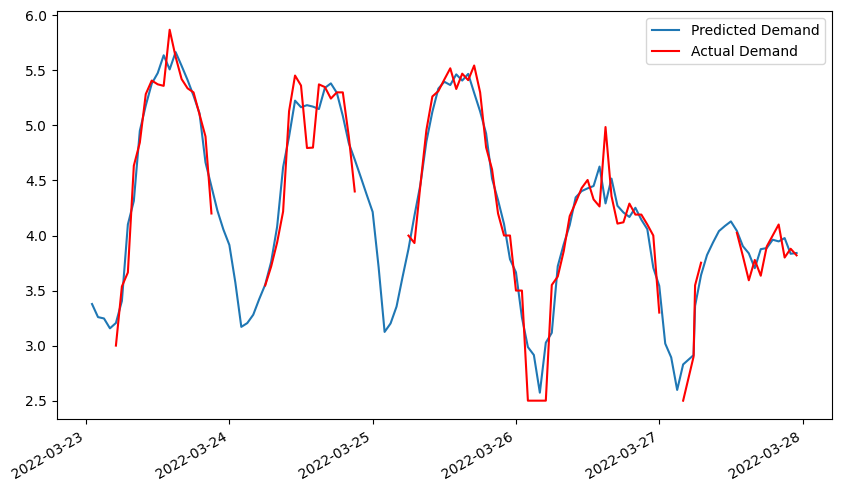

In [22]:
# Visualize the data
start_time_ana = pd.to_datetime('2022-03-23')
end_time_ana = pd.to_datetime('2022-03-28')

filtered_data = predicted_data[(predicted_data.index>start_time_ana) & (predicted_data.index<end_time_ana)]

fig, ax1 = plt.subplots(figsize=(10, 6))
plt.plot(filtered_data.index, filtered_data['PredictedPower'])
plt.plot(filtered_data.index, filtered_data['Power'], color='red')
fig.autofmt_xdate()
plt.legend(['Predicted Demand', 'Actual Demand'])
plt.plot()

In [25]:
# Score of the predicted values wrt actual
df = predicted_data.dropna(subset=['Power'])
r2 = r2_score(df['Power'], df['PredictedPower'])
print("R-squared Score:", r2)

R-squared Score: 0.9386065911980424
